# QAOA with Amazon Braket Hybrid Job and PennyLane
In this tutorial we show how to solve a max-cut problems using the Quantum Approximate Optimization Algorithm (QAOA). The QAOA algorithm is a hybrid quantum algorithms that involves optimizing an objective function by running both classical and quantum computers in an alternating manner. Amazon Braket Hybrid Job is a perfect solution for this type of problem. In the following, we show how to set up the problem, prepare input data and put together and the orchestration script.

## Problem setup
We first create and visualize a random graph for the max-cut problem with <code>networkx</code> package. Feel free to play with the number of nodess, <code>n</code>, and number of edges, <code>m</code>.

In [1]:
import tempfile
import time
import networkx as nx

from braket.aws import AwsQuantumJob, AwsSession

from braket.jobs.config import (
    InstanceConfig,
    OutputDataConfig,
    StoppingCondition
)
from braket.jobs.image_uris import Framework, retrieve_image

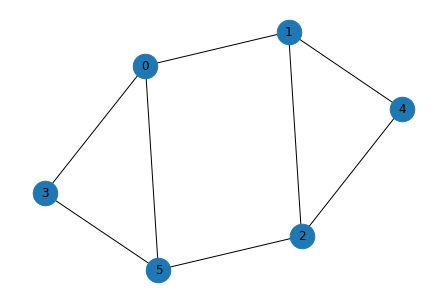

In [2]:
# We generate a random graph with num_nodes nodes and num_edges edges to run Max Cut on.
# num_nodes is the number of qubits, so each circuit will have runtime exponential in num_nodes
num_nodes = 6
num_edges = 8
seed = 1967
    
graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

## Prepare input data
We also need to prepare the input data for training. The input data can be forwarded through a dirctionary or through a S3 bucket. In this notebook, the input data is the random graph we created. We will upload the graph to a s3 bucket and provide the URI of the s3 bucket to the orchestration script.

In [3]:
# Function to upload the graph to S3 in an adjacency list format
def setup_input_stream():
    with tempfile.NamedTemporaryFile() as temp_graph_file:
        # define the uri for our input data stream
        stream_s3_uri = aws_session.construct_s3_uri(
            aws_session.default_bucket(),
            "input-graph",
        )
        # Write graph to a temporary file
        nx.write_adjlist(graph, temp_graph_file.name)
        # Upload temporary file to S3
        aws_session.upload_to_s3(temp_graph_file.name, f"{stream_s3_uri}/input-data.adjlist")
    return stream_s3_uri

In [4]:
# Job output data will be sent to this bucket by default,
# unless output_data_config is specified in "AwsQuantumJob.create".
aws_session = AwsSession()
bucket = aws_session.default_bucket()
print(bucket)

## Specify hyperparameters and configurations
The hyperparameters can be forwarded to the algorithm script throught the keyword argument <code>hyperparameters</code>. It usually includes, but not limited to, the numbers that are requred to define a training procedure, such as the number of iteration, or to set up an optimizer, such as the learning rate. Here, we pack these hyparameters into a dictionary which will later become the input of the orchestration script. <code>device_arn</code> has a dedicated input channel so we do not include it in the hyperparameters.

In [5]:
# Pick 'autograd', 'tf', or 'torch'. Autograd is base PennyLane
interface = "autograd"
# Specify device that the job will primarily be targeting
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
# Specify previous job arn to copy checkpoints from, or None to not copy checkpoints
copy_checkpoints_from_job = None
# copy_checkpoints_from_job = "arn:aws:braket:<region>:<your-account-id>:job/<job-name>"

hyperparameters = {
    # Number of tasks per iteration = 2 * (num_nodes + num_edges) * p + 1
    "p": "2",
    "seed": str(seed),
    # Maximum number of simultaneous tasks allowed
    "max_parallel": "10",
    # Number of total optimization iterations, including those from previous checkpoint (if any)
    "num_iterations": "5",
    # Step size / learning rate for gradient descent
    "stepsize": "0.1",
    # Shots for each circuit execution
    "shots": "1000",
    "interface": interface,
}
if copy_checkpoints_from_job:
    hyperparameters['copy_checkpoints_from_job'] = copy_checkpoints_from_job

Braket Job has three pre-built containers. We need to use either the TF or PyTorch container because we are using PennyLane. 

In [6]:
region = aws_session.region

# Choose the container based on which one we need.
if interface == 'autograd':
    # Base container does not have PennyLane, so we have to use the TF or PyTorch container
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == 'tf':
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == 'torch':
    image_uri = retrieve_image(Framework.PL_PYTORCH, region)

## Algorithm script
The complete algorithm script for solving the max-cut problem with QAOA is [here](qaoa_source/qaoa_algorithm_script.py). See [this page](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html) for details about using QAOA with Pennylane, and [this repo](https://github.com/aws/amazon-braket-examples) for example notebooks.

## Orchestration script
We have now finished preparing input data, algorithm script, hyperparameters and other configurations. It time to submit out Braket Job!

In [7]:
start_time = time.time()

job = AwsQuantumJob.create(
    device_arn=device_arn,
    source_module="qaoa_source",
    # Any unique name works. Note 50-character limit in job name
    # (comment out to use default naming)
    job_name="JobTest-"+interface+"-"+str(int(time.time())),
    image_uri=image_uri,
    # Relative to the current location
    entry_point="qaoa_source.qaoa_algorithm_script:start_here",
    copy_checkpoints_from_job=copy_checkpoints_from_job,
    # general parameters
    hyperparameters=hyperparameters,
    input_data={
        "input-graph": setup_input_stream()
    },
    # Comment out the following line if you want to run the job
    # silently and asynchronously
    wait_until_complete=True,
)

end_time = time.time()

In [8]:
print(end_time - start_time)

397.9432189464569


## View results

After the job is completed, we can view the result and the metric we defined in the algorithm script.

In [9]:
print(job.result())

{'params': [[0.29045119576374073, 0.3090312068052205], [-0.04545138802088256, -0.11371989905871666]], 'cost': -4.903}


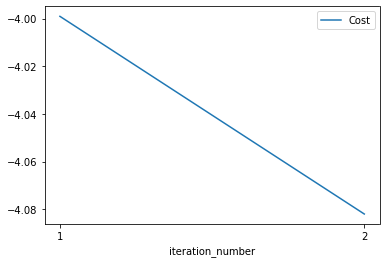

In [10]:
# A demonstration of plotting the metrics

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

df = pd.DataFrame(job.metrics())

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
figure = df.plot(x='iteration_number', y='Cost', ax=ax)

In [11]:
# May need to wait a bit before metrics show up
# If metrics aren't there, run a bit later
# time.sleep(120)
print(job.metrics())

{'timestamp': [1635951531.1797922, 1635951506.276847], 'Cost': [-4.082, -3.999], 'iteration_number': [2.0, 1.0]}


## Other records

Braket Job also records logs and metadata. If you wish to access the job at a later day, you can retrieve it by its arn which you can found by <code>job.arn</code> or by checking the Braket Job console. 

In [12]:
print(job.arn)

In [13]:
print(job.metadata())

In [14]:
# Run this cell to reprint logs from CloudWatch
job.logs()

In [15]:
# Downloads results to current directory
job.download_result()